# Farfetch DS Exercise
## March 2nd, 2017
### Dr Jose M Albornoz

# Import necessary modules

In [2]:
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import cm
style.use('fivethirtyeight')
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples
from sklearn import metrics
from sklearn.datasets import make_blobs

RANDOM_STATE = 801

# 1 Detecting a marketing promotion - Completed in 2 hours

### In the data file named marketing_promo.csv you will find data related to traffic and order activity over a period of several months. During this period a promotion offering free shipping was launched on the website. All visitors were exposed to the promotion and once started it remained active for all of the remaining days in the data you have available.

### Based on the available data, deduce which day the promotion was launched.


## 1.1 Load data

In [3]:
marketing_0 = pd.read_csv('marketing_promo.csv')

In [4]:
marketing_0.head()

,Day,visits,orders
0,1,3316,17
1,2,3654,23
2,3,3437,14
3,4,3368,5
4,5,3588,16


In [5]:
marketing_0.shape

(122, 3)

### The data represents web site visits and orders during a period of 122 days

## 1.2 Exploratory analysis: plot data

### We want to have an idea of what the 'visits' and 'orders' time series look like

(0, 122)

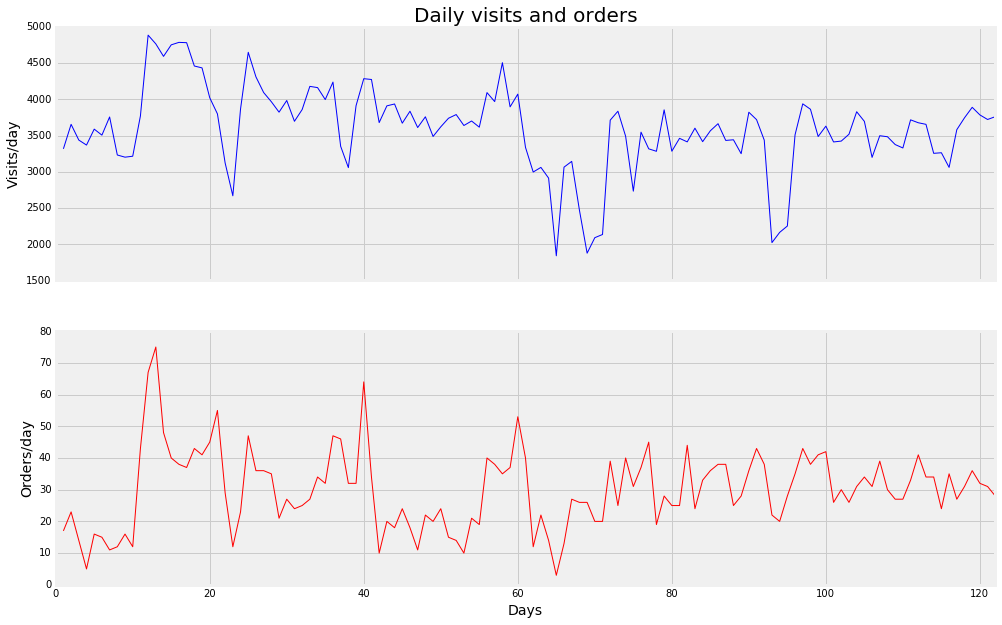

In [6]:
f, axarr = plt.subplots(2, sharex=True, figsize=(15,10), dpi=100)

axarr[0].plot(marketing_0.Day, marketing_0.visits, color="blue", linewidth=1.0, linestyle="-")
axarr[0].set_title('Daily visits and orders', fontsize=20)
axarr[0].set_ylabel('Visits/day', fontsize=14)

axarr[1].plot(marketing_0.Day, marketing_0.orders, color="red", linewidth=1.0, linestyle="-")
axarr[1].set_ylabel('Orders/day', fontsize=14)
axarr[1].set_xlabel('Days', fontsize=14)
axarr[1].set_xlim(0,122)

### As seen from the above plots, there are no obvious indications of a rise in visits and/or orders that could signal the start of the promotion.

### A better proxy of the effect of the promotion is the daily average number of orders per visit, obtained by dividing number of orders by the number of visits:

In [7]:
marketing_0['orders_per_visit'] = marketing_0['orders']/marketing_0['visits']

(0, 122)

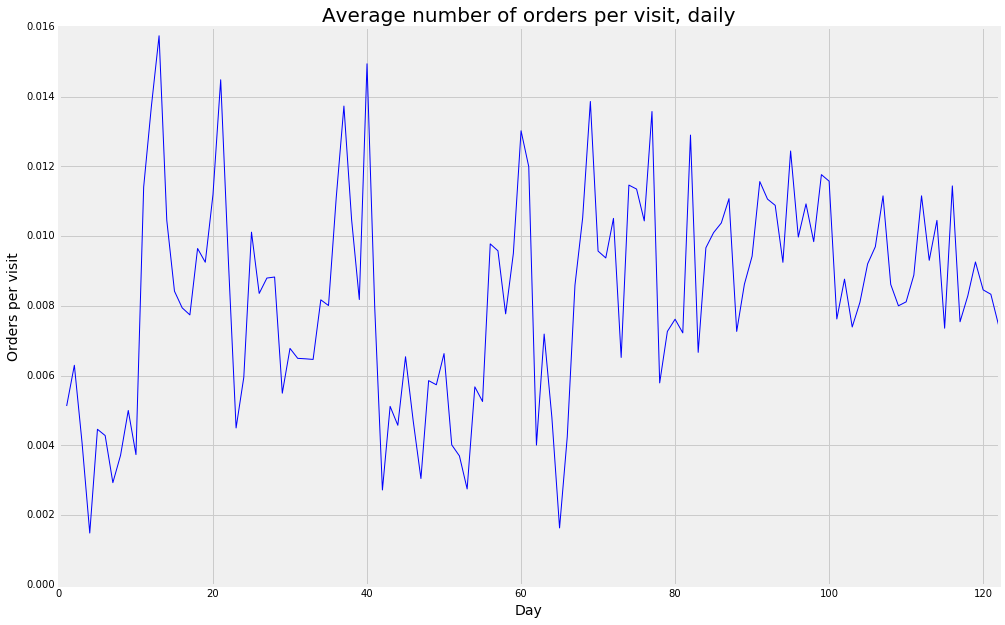

In [8]:
fig = plt.figure(figsize=(15,10))

plt.plot(marketing_0.Day, marketing_0['orders_per_visit'], color="blue", linewidth=1.0, linestyle="-")
plt.xlabel('Day', fontsize=14)
plt.ylabel('Orders per visit', fontsize=14)
plt.title('Average number of orders per visit, daily', fontsize=20)
plt.xlim(0,122)

### Once again, there are no obvious indications of the start of the promotion in the orders per visit time series. 
### We will now look at the daily percent change in the average number of orders per visit in order to come up with a simple change point estimate.

## 1.3 Change point estimation

### In order to come up with an estimate of the start date of the promotion we will now look at the (standarised) daily percent change in the average number of orders per visit. 

In [20]:
marketing_0['orders_per_visit_percent_change'] = marketing_0['orders_per_visit'].pct_change(periods=1)

marketing_0['orders_per_visit_percent_change_standarised'] = \
(marketing_0['orders_per_visit_percent_change'] - marketing_0['orders_per_visit_percent_change'].mean())/ \
marketing_0['orders_per_visit_percent_change'].std()

(0, 122)

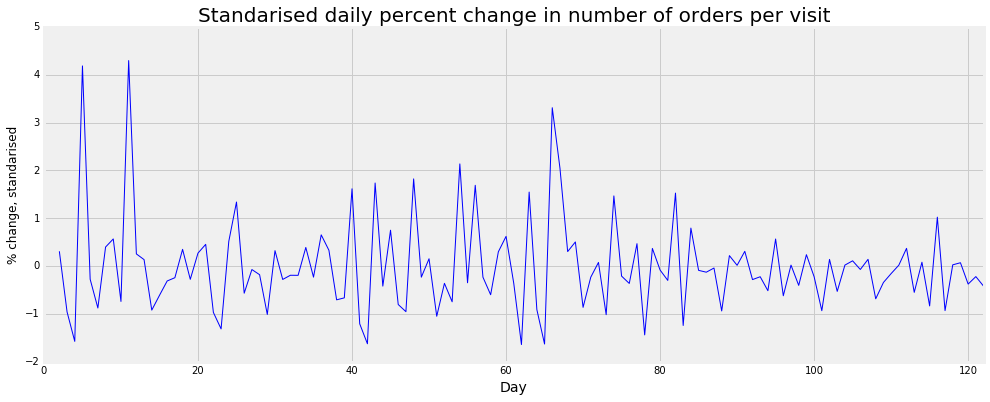

In [22]:
fig = plt.figure(figsize=(15,6))
plt.plot(marketing_0.Day, marketing_0['orders_per_visit_percent_change_standarised'], color="blue", 
         linewidth=1.0, linestyle="-")
plt.xlabel('Day', fontsize=14)
plt.ylabel('% change, standarised')
plt.title('Standarised daily percent change in number of orders per visit', fontsize=20)
plt.xlim(0,122)

### As seen in the above plot, there are two points in time in which percentual increases in the daily average number of orders per visit are over 4 standard deviations above the mean; these events are observed i the frist 10 days of the series. Let's take a closer look at this period:

(0, 20)

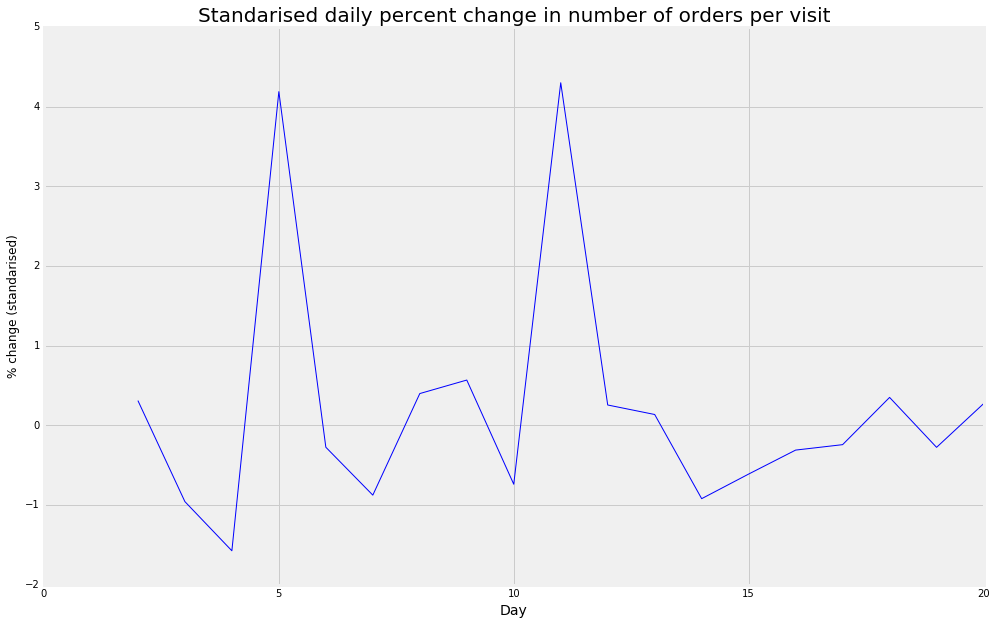

In [23]:
fig = plt.figure(figsize=(15,10))

plt.plot(marketing_0.Day, marketing_0['orders_per_visit_percent_change_standarised'], color="blue", 
         linewidth=1.0, linestyle="-")
plt.xlabel('Day', fontsize=14)
plt.ylabel('% change (standarised)')
plt.title('Standarised daily percent change in number of orders per visit', fontsize=20)
plt.xlim(0,20)

### The first increase in the number of orders per visit happens on day 5; therefore we conclude that the promotion started on day 5.

In [18]:
marketing_0['orders_per_visit_percent_change_standarised'] = \
(marketing_0['orders_per_visit_percent_change'] - marketing_0['orders_per_visit_percent_change'].mean())/ \
marketing_0['orders_per_visit_percent_change'].std()

(0, 20)

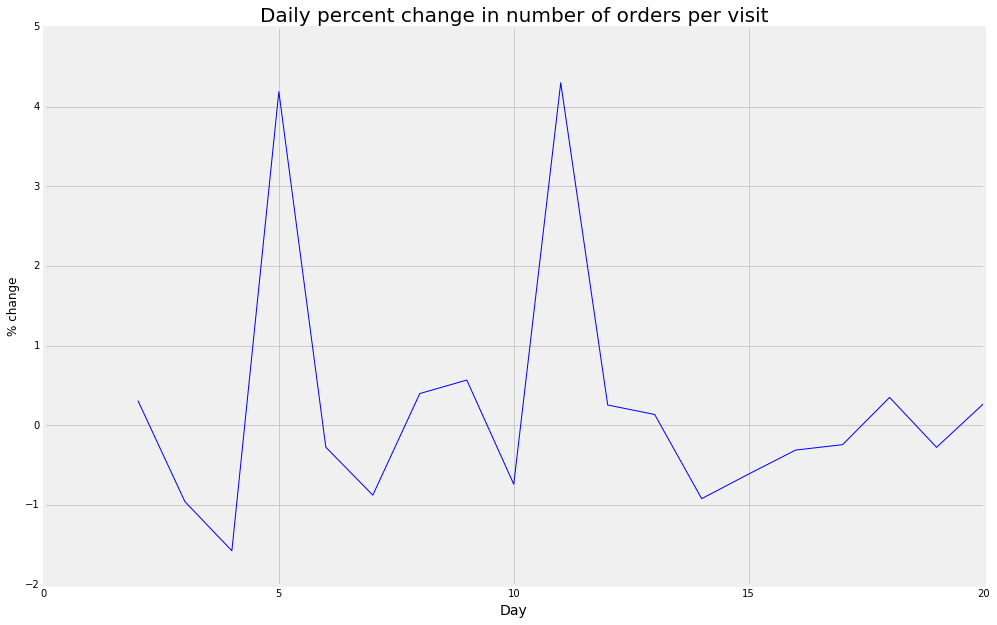

In [19]:
fig = plt.figure(figsize=(15,10))

plt.plot(marketing_0.Day, marketing_0['orders_per_visit_percent_change_standarised'], color="blue", linewidth=1.0, linestyle="-")
plt.xlabel('Day', fontsize=14)
plt.ylabel('% change')
plt.title('Daily percent change in number of orders per visit', fontsize=20)
plt.xlim(0,20)

# 2 Clustering - Completed in 1.5 days

### In the data file named cluster_data.cv you will find a dataset, where each row represents a data point. The dataset is artificially generated. Explain how you think the data was generated, including how many clusters are in the data and their centroid positions.

## 2.1 Load data

In [26]:
clustering_0 = pd.read_csv('clustering_data.csv', header=None)

### For the sake of the exercise we will give arbitrary names to the features in this dataset.

In [27]:
clustering_0.columns = ['F1', 'F2', 'F3', 'F4', 'F5']

In [28]:
clustering_0.head()

,F1,F2,F3,F4,F5
0,9.867585,21.787221,20.113157,15.892429,19.180627
1,-9.357452,-15.005907,-10.498652,-8.608220,-7.057452
2,-15.704679,-17.867917,-13.475520,-16.897009,-13.443890
3,21.199188,22.555756,18.634152,20.666434,17.455580
4,112.268019,97.873333,68.139400,164.779071,91.519554


In [29]:
clustering_0.shape

(5300, 5)

### We will now generate a few exploratory plots in order to get an idea of what the data looks like.

## 2.2 Exploratory 2D plots

### Histograms for each feature are plotted to get a sense of the scale of each feature and its distribution; we also look at each feature's mean and standard deviation

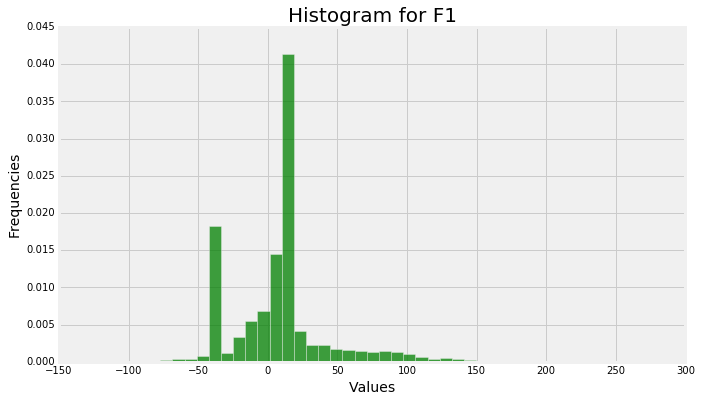

In [72]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(clustering_0['F1'], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('Histogram for F1', fontsize=20)
plt.xlabel('Values', fontsize=14)
plt.ylabel('Frequencies', fontsize=14)

In [356]:
clustering_0['F1'].mean()

7.469529068590564

In [358]:
clustering_0['F1'].std()

36.29662649287279

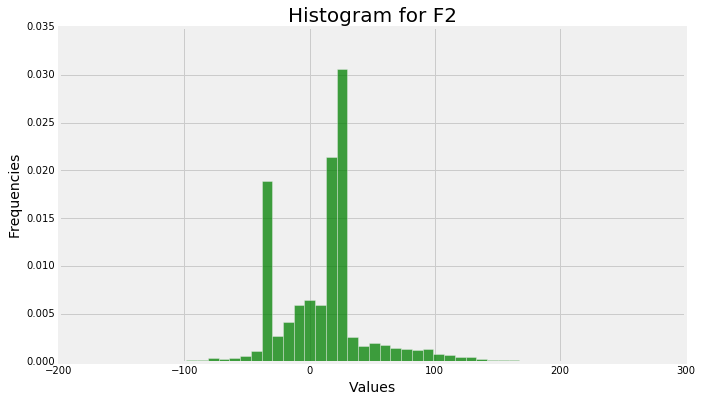

In [80]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(clustering_0['F2'], 50, normed=1, facecolor='green', alpha=0.750)
plt.title('Histogram for F2', fontsize=20)
plt.xlabel('Values', fontsize=14)
plt.ylabel('Frequencies', fontsize=14)

In [360]:
clustering_0['F2'].mean()

12.065585906214942

In [361]:
clustering_0['F2'].std()

37.78060035696488

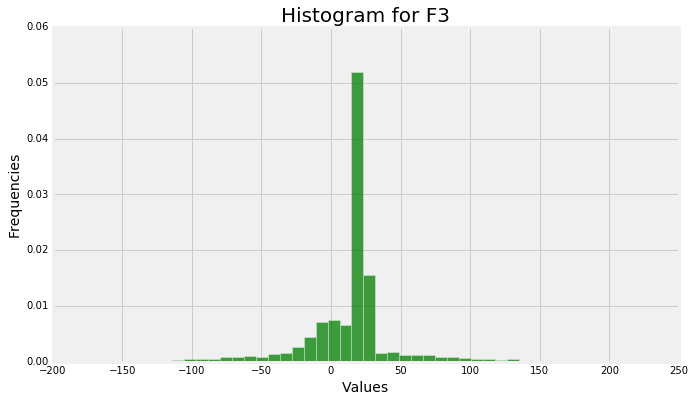

In [74]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(clustering_0['F3'], 50, normed=1, facecolor='green', alpha=0.750)
plt.title('Histogram for F3', fontsize=20)
plt.xlabel('Values', fontsize=14)
plt.ylabel('Frequencies', fontsize=14)

In [362]:
clustering_0['F3'].mean()

13.354315476373454

In [363]:
clustering_0['F3'].std()

33.94786314249668

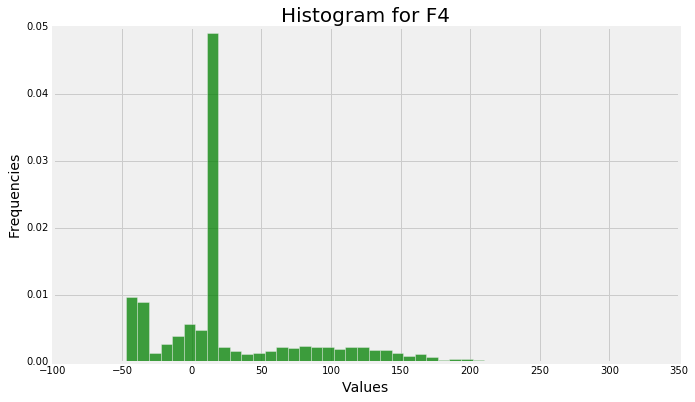

In [181]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(clustering_0['F4'], 50, normed=1, facecolor='green', alpha=0.750)
plt.title('Histogram for F4', fontsize=20)
plt.xlabel('Values', fontsize=14)
plt.ylabel('Frequencies', fontsize=14)

In [364]:
clustering_0['F4'].mean()

27.691199484245182

In [365]:
clustering_0['F4'].std()

54.85704514572216

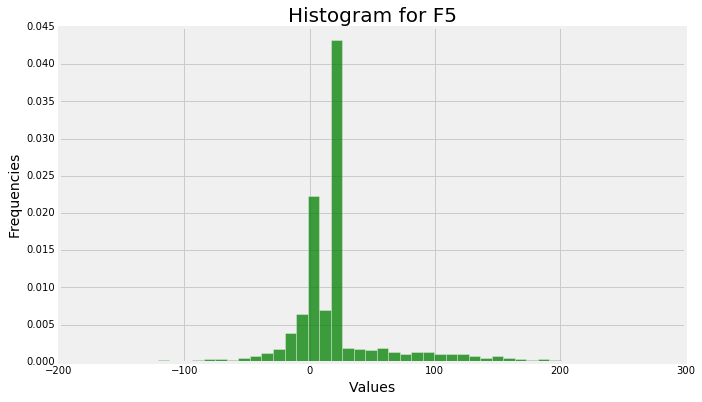

In [76]:
plt.figure(figsize=(10,6), dpi=80)
n, bins, patches = plt.hist(clustering_0['F5'], 50, normed=1, facecolor='green', alpha=0.750)
plt.title('Histogram for F5', fontsize=20)
plt.xlabel('Values', fontsize=14)
plt.ylabel('Frequencies', fontsize=14)

In [366]:
clustering_0['F5'].mean()

22.04485255243439

In [367]:
clustering_0['F5'].std()

43.563109504979934

### These histograms show that:

1. All the features have roughly the same scale, and therefore it will not be necessary to re-scale the data when searching for clusters.
2. Aside from F4, all feature histograms look roughly gaussian-shaped. 
3. Aside from F4, all feature histograms are roughly centered around 0.
4. Feature F4 seems to be associated with the presence of two clusters, as evidence by the bimodal histogram for this feature.
5. All histograms have some bins with inordinate counts.
6. Features F1, F2 and F3 have roughly the same standard deviation, whilst features F4 and F5 have a larger spread
7. 

## 2.3 Exploratory 3D plots

### We now show some 3D plots of the dataset that reveal the presence of at least 2 clusters in the data; all of these plots include feature F4, in agreement with what was seen in the histogram for this feature.

<IPython.core.display.Javascript object>


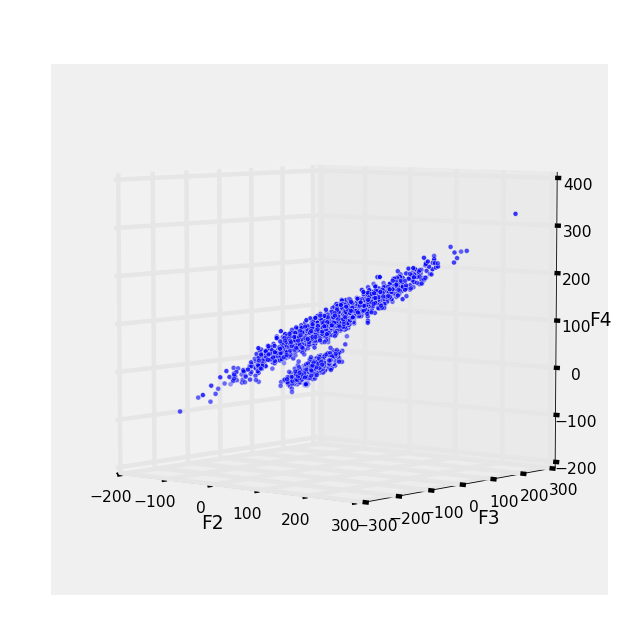

In [66]:
threedee = plt.figure(figsize=(8,8)).gca(projection='3d')
threedee.scatter(clustering_0['F2'], clustering_0['F3'], clustering_0['F4'])
threedee.set_xlabel('F2')
threedee.set_ylabel('F3')
threedee.set_zlabel('F4')
plt.show()

<IPython.core.display.Javascript object>


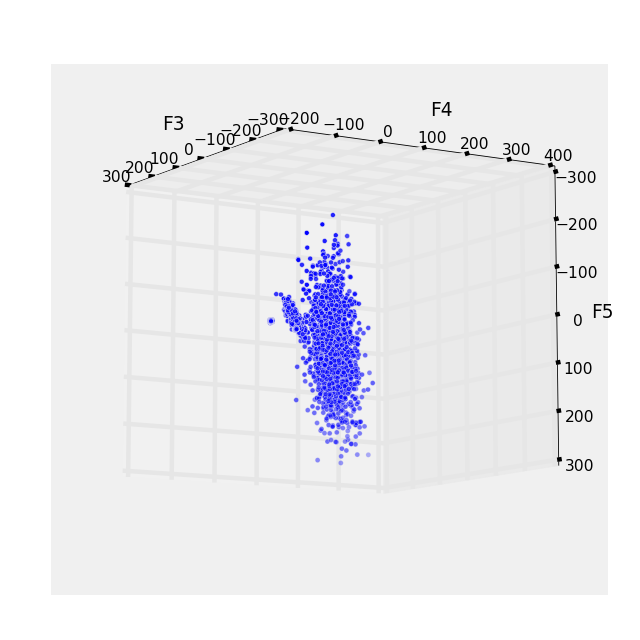

In [68]:
threedee = plt.figure(figsize=(8,8)).gca(projection='3d')
threedee.scatter(clustering_0['F3'], clustering_0['F4'], clustering_0['F5'])
threedee.set_xlabel('F3')
threedee.set_ylabel('F4')
threedee.set_zlabel('F5')
plt.show()

<IPython.core.display.Javascript object>


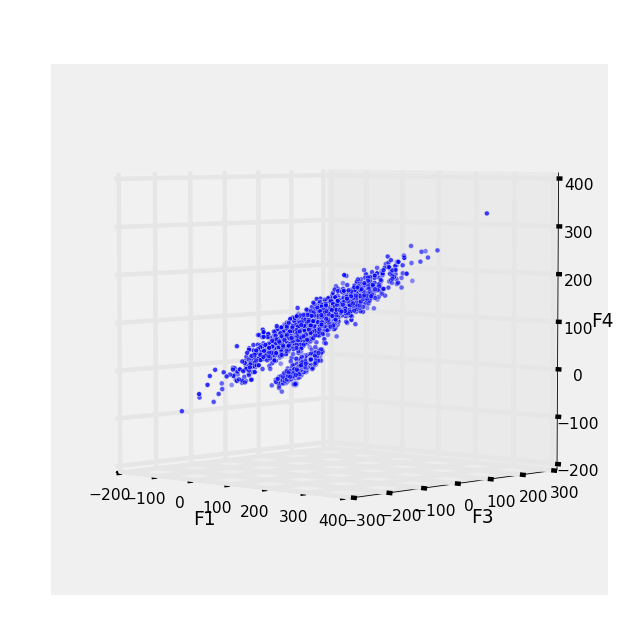

In [69]:
threedee = plt.figure(figsize=(8,8)).gca(projection='3d')
threedee.scatter(clustering_0['F1'], clustering_0['F3'], clustering_0['F4'])
threedee.set_xlabel('F1')
threedee.set_ylabel('F3')
threedee.set_zlabel('F4')
plt.show()

<IPython.core.display.Javascript object>


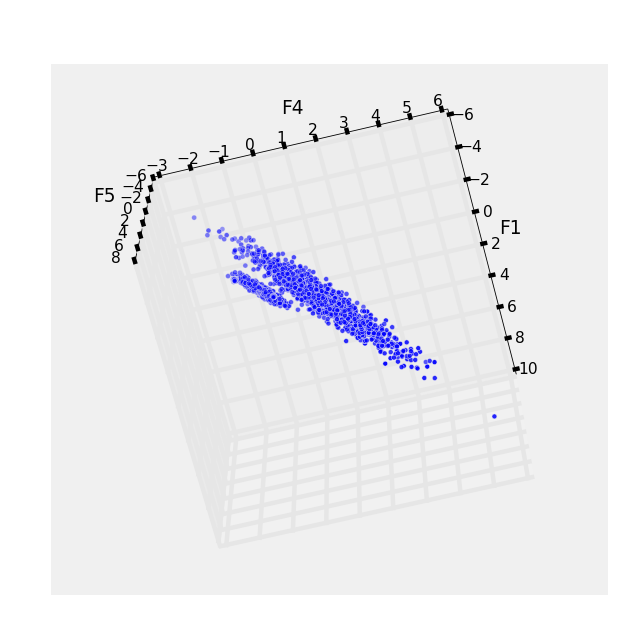

In [195]:
threedee = plt.figure(figsize=(8,8)).gca(projection='3d')
threedee.scatter(clustering_0[:,0], clustering_0[:,3], clustering_0[:,4])
threedee.set_xlabel('F1')
threedee.set_ylabel('F4')
threedee.set_zlabel('F5')
plt.show()

## 2.4 k-means clustering

### We will use the k-means algorithm as a first approximation to the task of detecting clusters in the data. Guided by the exploratory plots, we will fist standarise the dataset and then k-means will be run for k = 2 and k = 3 clusters.

### 2.4.1 Feature standardisation

In [287]:
scl = StandardScaler()    

In [288]:
clustering_1 = scl.fit_transform(clustering_0)

### 2.4.2 k-means clustering with k = 2

In [289]:
km = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=RANDOM_STATE)

In [290]:
clusters_km = km.fit_predict(clustering_1)

In [291]:
km.inertia_

14312.558239538883

In [292]:
km.cluster_centers_

array([[-0.27271142, -0.25890485, -0.19844474, -0.31023765, -0.27422886],
       [ 1.7803717 ,  1.69023676,  1.29552848,  2.02535826,  1.79027816]])

In [293]:
centers = km.cluster_centers_

<IPython.core.display.Javascript object>


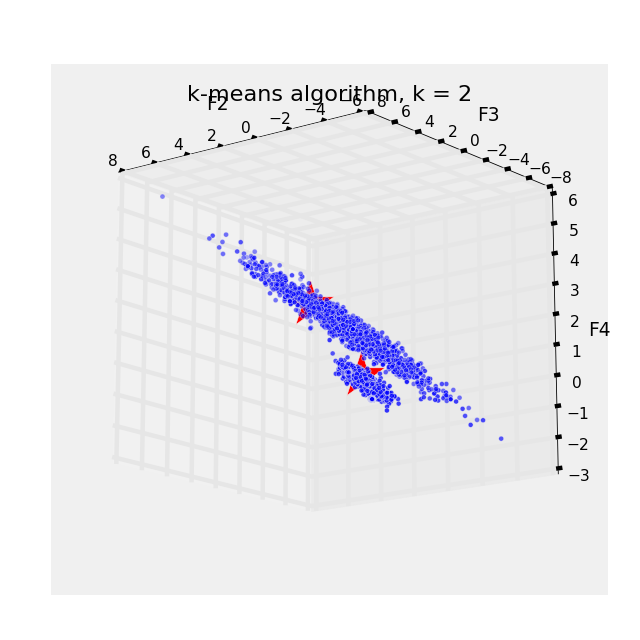

In [294]:
%matplotlib notebook
threedee = plt.figure(figsize=(8,8)).gca(projection='3d')
threedee.scatter(clustering_1[:,1], clustering_1[:,2], clustering_1[:,3])
threedee.set_xlabel('F2')
threedee.set_ylabel('F3')
threedee.set_zlabel('F4')
threedee.scatter(centers[0,1], centers[0,2], centers[0,3], c='red', s=2000, marker = '*')
threedee.scatter(centers[1,1], centers[1,2], centers[1,3], c='red', s=2000, marker = '*')
plt.title('k-means algorithm, k = 2')
plt.show()

### 2.4.3 k-means clustering with k = 3

In [295]:
km = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=RANDOM_STATE)

In [296]:
clusters_km = km.fit_predict(clustering_1)

In [297]:
km.inertia_

10056.390617032655

In [298]:
km.cluster_centers_

array([[ -1.04753158e+00,  -1.12285544e+00,  -4.66455200e-01,
         -8.41409371e-01,  -6.11362774e-01],
       [  1.91325948e+00,   1.84062673e+00,   1.49945405e+00,
          2.13190021e+00,   1.99944779e+00],
       [  1.41202880e-01,   1.90873416e-01,  -5.88478976e-02,
          1.54269886e-03,  -8.35545426e-02]])

In [299]:
centers = km.cluster_centers_

<IPython.core.display.Javascript object>


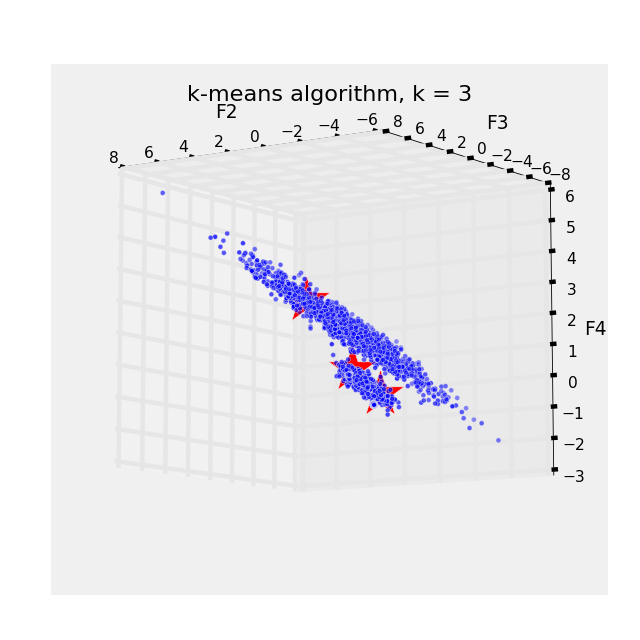

In [300]:
%matplotlib notebook
threedee = plt.figure(figsize=(8,8)).gca(projection='3d')
threedee.scatter(clustering_1[:,1], clustering_1[:,2], clustering_1[:,3])
threedee.set_xlabel('F2')
threedee.set_ylabel('F3')
threedee.set_zlabel('F4')
threedee.scatter(centers[0,1], centers[0,2], centers[0,3], c='red', s=2000, marker = '*')
threedee.scatter(centers[1,1], centers[1,2], centers[1,3], c='red', s=2000, marker = '*')
threedee.scatter(centers[2,1], centers[2,2], centers[2,3], c='red', s=2000, marker = '*')
plt.title('k-means algorithm, k = 3')
plt.show()

### There seem to be **at least 2 clusters** in the dataset, as suggested by the above plots.  

### 2.4.3 Elbow and silhouette plots

### In order to get a better idea of the number of clusters in the data we will generate an elbow plot (also known as a scree plot) as well as silhouette plots.

#### 2.4.3.1 Elbow plot

In [301]:
distortions = []
for i in range(1, 20):
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=RANDOM_STATE)
    km.fit(clustering_1)
    distortions.append(km.inertia_)

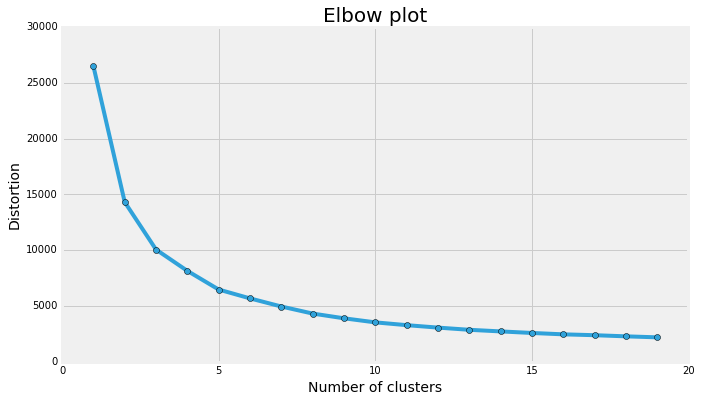

In [302]:
%matplotlib inline
plt.figure(figsize=(10,6), dpi=80)
plt.plot(range(1,20), distortions, marker='o')
plt.xlabel('Number of clusters', fontsize=14)
plt.ylabel('Distortion', fontsize=14)
plt.title('Elbow plot', fontsize=20)

### Judging from the elbow plot, the reduction in distortion (within-cluster sum of squares) is less pronounced beyond k = 3 clusters. Let's now examine silhouette plots for k = 2 and k = 3 clusters.

#### 2.4.3.2 Silhouette plot for k = 2

In [310]:
km = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=RANDOM_STATE)
y_km = km.fit_predict(clustering_1)

In [311]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]

In [312]:
silhouette_vals = silhouette_samples(clustering_1, y_km, metric='euclidean')

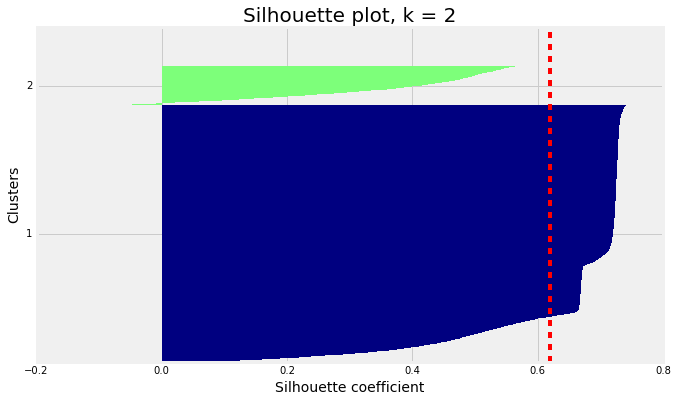

In [315]:
plt.figure(figsize=(10,6), dpi=80)
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.title('Silhouette plot, k = 2', fontsize=20)
plt.ylabel('Clusters', fontsize=14)
plt.xlabel('Silhouette coefficient', fontsize=14)

#### 2.4.3.3 Silhouette plot for k = 3

In [316]:
km = KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=RANDOM_STATE)
y_km = km.fit_predict(clustering_1)

In [317]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]

In [318]:
silhouette_vals = silhouette_samples(clustering_1, y_km, metric='euclidean')

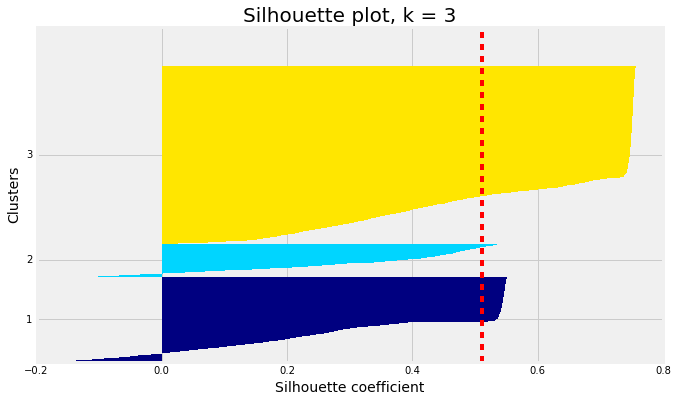

In [319]:
plt.figure(figsize=(10,6), dpi=80)
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.title('Silhouette plot, k = 3', fontsize=20)
plt.ylabel('Clusters', fontsize=14)
plt.xlabel('Silhouette coefficient', fontsize=14)

### The silhouette plot for k = 2 shows: 
 - one large cluster whose points are far away from the neighbouring cluster (the silhouette coefficients for all its points are greater than the average silhouette coefficient represented by the red dotted vertical line)
 - one smaller cluster whose points are not very far away from from the neighbouring cluster, as its silhouette coefficient is below the average.
 
### The silhouette plot for k = 3 shows:
 - three clusters whose silhouette values are all above average, with one of the clusters being a large one with large silhouette values.
 - the other two clusters have some misassigned samples as evidenced by the negative silhouette values.
 
### So far the results of our exploration are still ambiguous. In order to find additional evidence for the number of clusters, we will run DBSCAN on the dataset.

## 2.5 DBSCAN

### The main parameters for the DBSCAN algorithm are i) eps, the maximum distance between two samples for them to be considered to be in the same neighborhood; ii) min_samples, the number of samples in a neighborhood for a point to be considered as a core point. 

### Given what we have observed in the exploratory plots, an educated guess for these values is eps = 0.5 and min_samples = 50

### 2.5.1 DBSCAN algorithm, min_samples = 10

In [346]:
db = DBSCAN(eps=0.5, min_samples=50, metric='euclidean')

In [347]:
db.fit(clustering_1)

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    min_samples=50, n_jobs=1, p=None)

In [348]:
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [349]:
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [350]:
n_clusters_

2

### These results indicate the presence of two clusters. It must be remarked that the process of selecting the optimun number of clusters is to a degree subjective, and that it should take into account domain knowledge and/or business considerations.

### In order to find the cluster centres, we will run k-means again on the original dataset (since all feature have the same scale)

In [352]:
km = KMeans(n_clusters=2, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=RANDOM_STATE)

In [353]:
clusters_km = km.fit_predict(clustering_0.values)

In [355]:
km.cluster_centers_

array([[  -2.97315121,    1.75701388,    6.57844323,    8.83543062,
           9.07302614],
       [  66.29619234,   70.13677826,   51.5247798 ,  133.9112441 ,
          95.11893351]])

### To summarise:
1. The features in the dataset could have been generated using normally distributed variables that were then suitably distorted by adding additional values, and/or by adding together normally diitributed variables with a different mean (as in the cases of features F4 and F5)
2. Two clusters were identified in the dataset
3. the centres of these clusters are given above in the variable km.cluster_centers_